# Building a Plan-and-Execute Agent in LangGraph

Build a plan-and-execute agent using LangGraph. This agent will:

- Plan a series of steps to answer complex, multi-step queries.
- Execute each step using tools and an LLM.
- Re-plan if necessary, updating the plan based on intermediate results.

### Overview
Our agent will:

1. Receive a complex query from the user.
2. Plan a sequence of steps to answer the query.
3. Execute each step, possibly using tools (like web search).
4. Re-plan if needed, adjusting the plan based on new information.
5. Provide the final answer to the user.


### Imports
We start by importing the necessary libraries:


In [1]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import START, END
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
import os

from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

_ = load_dotenv()

### Defining the Model
We use the gpt-4o model from OpenAI:

In [2]:
# Defining the model
llm = ChatOpenAI(
    model="openai/gpt-oss-120b:free",  
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature = 0
)

### Defining the Tools
We will define a web search tool using Tavily:

In [3]:
# Tavily Search Tool
tavily_search = TavilySearch(max_results=3)

# List of tools for the agent
tools = [tavily_search]

### Defining the State
Our agent needs to maintain state across planning and execution steps. We define the State as follows:

In [4]:
class State(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple[str, str]], operator.add]  # List of (step, result)
    response: str

### Planning Step
We create a planning function that generates a plan based on the user's query:

In [5]:
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(description="A list of steps to achieve the objective.")

from langchain_core.prompts import ChatPromptTemplate
import json
import re

planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are a planning assistant that creates a simple, step-by-step plan to answer the user's query.

IMPORTANT: You must respond with a valid JSON object in this exact format:
{
    "steps": ["step 1 description", "step 2 description", "step 3 description"]
}

Each step should be a clear, actionable task. Return ONLY valid JSON with a "steps" field containing an array of strings."""),
        ("user", "{input}")
    ]
)

# Create a robust planner with error handling
def create_robust_planner():
    """Create a planner that handles various response formats"""
    structured_planner = planner_prompt | llm.with_structured_output(Plan)
    
    def robust_planner(input_dict):
        try:
            # Try structured output first
            result = structured_planner.invoke(input_dict)
            # Validate that we got steps
            if hasattr(result, 'steps') and isinstance(result.steps, list):
                return result
            else:
                raise ValueError("Structured output missing steps field")
        except Exception as e:
            print(f"Structured output failed, trying fallback: {str(e)[:200]}")
            # Fallback: use regular LLM call and parse manually
            try:
                fallback_prompt = planner_prompt.invoke(input_dict)
                response = llm.invoke(fallback_prompt.messages)
                content = response.content if hasattr(response, 'content') else str(response)
                
                # Try to extract JSON from the response (handle various formats)
                # Look for JSON objects with either "steps" or "plan" field
                json_patterns = [
                    r'\{[^{}]*"steps"[^{}]*\[[^\]]*\][^{}]*\}',  # {"steps": [...]}
                    r'\{[^{}]*"plan"[^{}]*\[[^\]]*\][^{}]*\}',  # {"plan": [...]}
                ]
                
                for pattern in json_patterns:
                    json_match = re.search(pattern, content, re.DOTALL)
                    if json_match:
                        try:
                            json_str = json_match.group(0)
                            data = json.loads(json_str)
                            
                            # Handle "plan" field (convert to "steps")
                            if "plan" in data and isinstance(data["plan"], list):
                                steps_list = []
                                for item in data["plan"]:
                                    if isinstance(item, str):
                                        steps_list.append(item)
                                    elif isinstance(item, dict):
                                        # Extract step text from dict (e.g., {"step": 1, "description": "..."})
                                        if "description" in item:
                                            steps_list.append(item["description"])
                                        elif "step" in item:
                                            steps_list.append(str(item["step"]))
                                        elif "text" in item:
                                            steps_list.append(item["text"])
                                        else:
                                            # Use the first string value found
                                            for val in item.values():
                                                if isinstance(val, str) and len(val) > 3:
                                                    steps_list.append(val)
                                                    break
                                if steps_list:
                                    return Plan(steps=steps_list)
                            
                            # Handle "steps" field
                            if "steps" in data and isinstance(data["steps"], list):
                                steps_list = []
                                for item in data["steps"]:
                                    if isinstance(item, str):
                                        steps_list.append(item)
                                    elif isinstance(item, dict):
                                        # Extract step text from dict
                                        if "description" in item:
                                            steps_list.append(item["description"])
                                        elif any(k in item for k in ["step", "text", "action", "task"]):
                                            for key in ["step", "text", "action", "task"]:
                                                if key in item and isinstance(item[key], str):
                                                    steps_list.append(item[key])
                                                    break
                                if steps_list:
                                    return Plan(steps=steps_list)
                        except (json.JSONDecodeError, KeyError, TypeError) as parse_error:
                            print(f"JSON parsing failed: {str(parse_error)[:100]}")
                            continue
                
                # If JSON extraction fails, try to parse as a list from text
                lines = content.split('\n')
                steps = []
                for line in lines:
                    line = line.strip()
                    # Remove markdown formatting, numbers, bullets
                    line = re.sub(r'^[\*\-\d\.\)]\s*', '', line)
                    line = re.sub(r'^\*\*', '', line)
                    line = re.sub(r'\*\*$', '', line)
                    line = re.sub(r'^#+\s*', '', line)  # Remove markdown headers
                    # Remove JSON-like structures
                    if line and len(line) > 5 and not line.startswith('{') and not line.startswith('}') and not line.startswith('[') and not line.startswith(']'):
                        steps.append(line)
                
                if steps:
                    return Plan(steps=steps[:10])  # Limit to 10 steps
                
                # Last resort: create a simple plan based on the query
                query = input_dict.get('input', 'the query')
                return Plan(steps=[
                    f"Research information about: {query}",
                    "Gather relevant details",
                    "Compile and present the findings"
                ])
            except Exception as fallback_error:
                print(f"Fallback also failed: {str(fallback_error)[:200]}")
                # Ultimate fallback
                query = input_dict.get('input', 'the query')
                return Plan(steps=[
                    f"Research: {query}",
                    "Analyze the information",
                    "Provide the answer"
                ])
    
    return robust_planner

planner = create_robust_planner()

### Re-Plan Step
If necessary, the agent can re-plan based on previous results:


In [6]:
class Response(BaseModel):
    """Response to the user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(description="The action to perform next.")

replanner_prompt = ChatPromptTemplate.from_template(
    """
    You are a planning assistant that updates the plan based on completed steps and their results.

    Objective: {input}
    Original Plan: {plan}
    Completed Steps: {past_steps}

    Update the plan accordingly. If all steps are complete and you can provide the final answer, respond with the answer.
    """
)

# Create a robust replanner with error handling
def create_robust_replanner():
    """Create a replanner that handles various response formats"""
    structured_replanner = replanner_prompt | llm.with_structured_output(Act)
    
    def robust_replanner(state):
        try:
            # Try structured output first
            return structured_replanner.invoke(state)
        except Exception as e:
            print(f"Replanner structured output failed, trying fallback: {str(e)[:200]}")
            # Fallback: use regular LLM call and parse manually
            try:
                fallback_prompt = replanner_prompt.invoke(state)
                response = llm.invoke(fallback_prompt.messages)
                content = response.content if hasattr(response, 'content') else str(response)
                
                # Check if the response indicates completion
                if any(keyword in content.lower() for keyword in ['final answer', 'complete', 'finished', 'conclusion', 'summary']):
                    # Extract the answer from the response
                    return Act(action=Response(response=content))
                
                # Try to extract JSON from the response
                json_patterns = [
                    r'\{[^{}]*"steps"[^{}]*\[[^\]]*\][^{}]*\}',
                    r'\{[^{}]*"plan"[^{}]*\[[^\]]*\][^{}]*\}',
                ]
                
                for pattern in json_patterns:
                    json_match = re.search(pattern, content, re.DOTALL)
                    if json_match:
                        try:
                            json_str = json_match.group(0)
                            data = json.loads(json_str)
                            
                            # Handle "plan" field
                            if "plan" in data and isinstance(data["plan"], list):
                                steps_list = []
                                for item in data["plan"]:
                                    if isinstance(item, str):
                                        steps_list.append(item)
                                    elif isinstance(item, dict):
                                        if "description" in item:
                                            steps_list.append(item["description"])
                                        elif any(k in item for k in ["step", "text", "action", "task"]):
                                            for key in ["step", "text", "action", "task"]:
                                                if key in item and isinstance(item[key], str):
                                                    steps_list.append(item[key])
                                                    break
                                if steps_list:
                                    return Act(action=Plan(steps=steps_list))
                            
                            # Handle "steps" field
                            if "steps" in data and isinstance(data["steps"], list):
                                steps_list = []
                                for item in data["steps"]:
                                    if isinstance(item, str):
                                        steps_list.append(item)
                                    elif isinstance(item, dict):
                                        if "description" in item:
                                            steps_list.append(item["description"])
                                        elif any(k in item for k in ["step", "text", "action", "task"]):
                                            for key in ["step", "text", "action", "task"]:
                                                if key in item and isinstance(item[key], str):
                                                    steps_list.append(item[key])
                                                    break
                                if steps_list:
                                    return Act(action=Plan(steps=steps_list))
                        except (json.JSONDecodeError, KeyError, TypeError):
                            continue
                
                # If we have remaining plan steps, continue with them
                if state.get("plan") and len(state["plan"]) > 0:
                    return Act(action=Plan(steps=state["plan"]))
                
                # Otherwise, provide a response based on past steps
                past_steps_str = "\n".join([f"{step}: {result}" for step, result in state.get("past_steps", [])])
                return Act(action=Response(response=f"Based on the completed steps:\n{past_steps_str}\n\n{content}"))
            except Exception as fallback_error:
                print(f"Replanner fallback also failed: {str(fallback_error)[:200]}")
                # Ultimate fallback
                if state.get("plan") and len(state["plan"]) > 0:
                    return Act(action=Plan(steps=state["plan"]))
                else:
                    return Act(action=Response(response="Unable to complete the plan. Please try again with a different query."))
    
    return robust_replanner

replanner = create_robust_replanner()

### Defining the Execution Agent
We shall simply use the `create_agent` function to create an execution agent that can perform each step using the defined tools.

In [7]:
from langchain.agents import create_agent

execution_agent = create_agent(llm, tools)

### Creating the Graph
We define the nodes and edges of our LangGraph:

In [8]:
graph_builder = StateGraph(State)

# Planning node
def planning_node(state: State):
    print("Executing planning node...")
    # Call the planner function directly (it's not a Runnable, it's a function)
    plan = planner({"input": state["input"]})
    print(f"Plan created: {plan.steps}")
    return {"plan": plan.steps}

graph_builder.add_node("planner", planning_node)

# Execution node
def execution_node(state: State):
    print("Executing execution node...")
    # Check if plan is empty
    if not state.get("plan") or len(state["plan"]) == 0:
        print("Warning: No steps in plan, skipping execution")
        return {"plan": []}
    
    current_step = state["plan"][0]
    print(f"Current step: {current_step}")
    agent_input = f"Step: {current_step}\n\nPlease execute this step."
    
    try:
        # Fix: execution_agent expects messages in the correct format
        from langchain_core.messages import HumanMessage
        agent_response = execution_agent.invoke({"messages": [HumanMessage(content=agent_input)]})
        result = agent_response["messages"][-1].content
        print(f"Step result: {result}")
        return {
            "past_steps": [(current_step, result)],
            "plan": state["plan"][1:]  # Remove the executed step from the plan
        }
    except Exception as e:
        print(f"Error executing step: {str(e)[:200]}")
        # Return the step as failed but continue
        return {
            "past_steps": [(current_step, f"Error: {str(e)[:200]}")],
            "plan": state["plan"][1:]  # Remove the executed step from the plan
        }

graph_builder.add_node("executor", execution_node)

# Re-planning node
def replanning_node(state: State):
    print("Executing replanning node...")
    # Call the replanner function directly (it's not a Runnable, it's a function)
    output = replanner(state)
    if isinstance(output.action, Response):
        print(f"Replanning complete. Final response: {output.action.response}")
        return {"response": output.action.response}
    else:
        print(f"Replanning complete. Updated plan: {output.action.steps}")
        return {"plan": output.action.steps}

graph_builder.add_node("replanner", replanning_node)

# Conditional edge to decide whether to continue or end
def should_continue(state: State):
    print("Evaluating whether to continue...")
    if state.get("response"):
        print("Final response received. Ending execution.")
        return END
    elif state["plan"]:
        print("Plan steps remaining. Continuing to executor.")
        return "executor"
    else:
        print("No plan steps remaining. Moving to replanner.")
        return "replanner"

graph_builder.add_conditional_edges(
    "replanner",
    should_continue,
    {"executor": "executor", END: END}
)

# Defining edges
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "executor")
graph_builder.add_edge("executor", "replanner")
graph_builder.set_entry_point("planner")

### Compiling the Graph
We compile the graph to create a runnable agent:

In [9]:
# Setting up checkpointing for state management
memory = MemorySaver()

# Compiling the graph
graph = graph_builder.compile(checkpointer=memory)

### Visualizing the Agent's Workflow
We can visualize the agent's workflow:

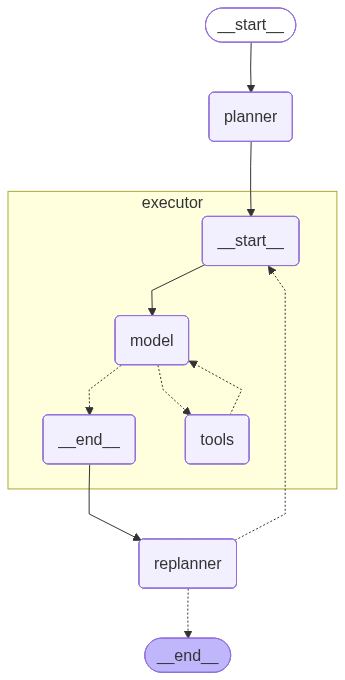

In [10]:
from IPython.display import display, Image

# Visualize the agent's workflow
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Agent
Now, we can interact with our agent.


In [11]:
from IPython.display import display, Markdown

user_query = "Which country will host the next FIFA World Cup, and what are the top three tourist attractions in its capital city?"
inputs = {"input": user_query}
config = {"recursion_limit": 50, "configurable": {"thread_id": "1"}}
events = graph.stream(inputs, config)
for event in events:
    for k, v in event.items():
        if k != "__end__":
            if isinstance(v, dict) and 'response' in v:
                display(Markdown(v['response']))

Executing planning node...
Structured output failed, trying fallback: 'Input to ChatPromptTemplate is missing variables {\'\\n    "steps"\'}.  Expected: [\'\\n    "steps"\', \'input\'] Received: [\'input\']\nNote: if you intended {\n    "steps"} to be part of the string
Fallback also failed: 'Input to ChatPromptTemplate is missing variables {\'\\n    "steps"\'}.  Expected: [\'\\n    "steps"\', \'input\'] Received: [\'input\']\nNote: if you intended {\n    "steps"} to be part of the string
Plan created: ['Research: Which country will host the next FIFA World Cup, and what are the top three tourist attractions in its capital city?', 'Analyze the information', 'Provide the answer']
Executing execution node...
Current step: Research: Which country will host the next FIFA World Cup, and what are the top three tourist attractions in its capital city?
Step result: **The next FIFA World Cup (2026) will be jointly hosted by three countries** – the United States, Canada, and Mexico. Because the 

Based on the completed steps:
Research: Which country will host the next FIFA World Cup, and what are the top three tourist attractions in its capital city?: **The next FIFA World Cup (2026) will be jointly hosted by three countries** – the United States, Canada, and Mexico. Because the tournament is a tri‑national event, each nation’s capital city can be highlighted as a gateway for visitors. Below are the three most‑visited tourist attractions in the capital of each host country.

| Host Country | Capital City | Top 3 Tourist Attractions (most‑visited / iconic) |
|--------------|--------------|---------------------------------------------------|
| **United States** | **Washington, D.C.** | 1. **National Mall & Memorial Parks** – the open‑air “museum” that includes the Lincoln Memorial, Washington Monument, World War II Memorial and the Reflecting Pool. <br>2. **Smithsonian Institution Museums** – a cluster of free‑admission museums (e.g., National Air & Space Museum, National Museum of American History, National Museum of Natural History). <br>3. **U.S. Capitol & Capitol Hill** – the seat of Congress, with guided tours of the historic Capitol building and the surrounding historic neighborhood. |
| **Canada** | **Ottawa** | 1. **Parliament Hill** – the iconic Gothic‑revival parliament buildings, daily Changing‑of‑the‑Guard ceremony and the nightly Sound and Light Show. <br>2. **Rideau Canal** – a UNESCO World Heritage Site that runs through the city; in summer it’s a scenic boat‑tour route, in winter it becomes the world’s largest skating rink. <br>3. **Canadian Museum of History** (across the river in Gatineau) – Canada’s most‑visited museum, showcasing Indigenous cultures, national history, and the famous “Grand Hall” with its giant totem pole. |
| **Mexico** | **Mexico City** | 1. **Zócalo (Plaza de la Constitución)** – one of the world’s largest public squares, surrounded by the Metropolitan Cathedral, National Palace and historic colonial architecture. <br>2. **Chapultepec Park & Castillo** – a massive urban park that houses Chapultepec Castle (the former imperial residence) and several museums, including the National Museum of Anthropology. <br>3. **Frida Kahlo Museum (Casa Azul)** – the former home of iconic artist Frida Kahlo in the Coyoacán neighborhood, now a vibrant museum of her life and work. |

### Quick Take‑away
- **The 2026 FIFA World Cup will be co‑hosted by the United States, Canada, and Mexico.**
- Visitors can base themselves in any of the three capitals—Washington, D.C.; Ottawa; or Mexico City—and enjoy the three flagship attractions listed above, each offering a distinct cultural and historical experience.
Analyze the information: I’m ready to help with the analysis, but I need the information you’d like me to examine. Could you please provide the data, text, or details you’d like analyzed? Once I have that, I can proceed with the requested step.
Provide the answer: I’m ready to give you the answer, but I need a bit more information about what you’d like answered. Could you please let me know the specific question or topic you’d like me to address?

**Answer**

The next FIFA World Cup (2026) will be **co‑hosted by three countries** – the **United States, Canada, and Mexico**. Because the tournament is shared among three nations, each capital city can serve as a gateway for visitors. Below are the three most‑visited / iconic tourist attractions in the capital of each host country.

| Host Country | Capital City | Top 3 Tourist Attractions (most‑visited / iconic) |
|--------------|--------------|---------------------------------------------------|
| **United States** | **Washington, D.C.** | 1. **National Mall & Memorial Parks** – open‑air “museum” that includes the Lincoln Memorial, Washington Monument, World War II Memorial and the Reflecting Pool.<br>2. **Smithsonian Institution Museums** – a cluster of free‑admission museums (e.g., National Air & Space Museum, National Museum of American History, National Museum of Natural History).<br>3. **U.S. Capitol & Capitol Hill** – seat of Congress, with guided tours of the historic Capitol building and the surrounding historic neighborhood. |
| **Canada** | **Ottawa** | 1. **Parliament Hill** – iconic Gothic‑revival parliament buildings, daily Changing‑of‑the‑Guard ceremony and the nightly Sound and Light Show.<br>2. **Rideau Canal** – UNESCO World Heritage Site; in summer a scenic boat‑tour route, in winter the world’s largest skating rink.<br>3. **Canadian Museum of History** (across the river in Gatineau) – Canada’s most‑visited museum, showcasing Indigenous cultures, national history, and the famous “Grand Hall” with its giant totem pole. |
| **Mexico** | **Mexico City** | 1. **Zócalo (Plaza de la Constitución)** – one of the world’s largest public squares, surrounded by the Metropolitan Cathedral, National Palace and historic colonial architecture.<br>2. **Chapultepec Park & Castillo** – massive urban park that houses Chapultepec Castle (former imperial residence) and several museums, including the National Museum of Anthropology.<br>3. **Frida Kahlo Museum (Casa Azul)** – former home of iconic artist Frida Kahlo in the Coyoacán neighbourhood, now a vibrant museum of her life and work. |

### Quick Take‑away
- **2026 FIFA World Cup hosts:** United States, Canada, and Mexico.  
- **Capital‑city highlights:** Washington D.C., Ottawa, and Mexico City each offer three flagship attractions that give visitors a rich cultural, historical, and recreational experience.